In [ ]:
# from __future__ import print_function, division
import os,random

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from tqdm.notebook import tqdm
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix

)

import time
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive
!cp data.zip /content/

/content/drive/My Drive


In [ ]:
%cd /content/
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/Tomato___Septoria_leaf_spot/ef8a4469-0126-4d5d-875a-ce5e88f6eba7___Matt.S_CG 7739.JPG  
  inflating: data/train/Tomato___Septoria_leaf_spot/ef9c5aec-0f5e-42d3-8d37-9e1da11ead91___Matt.S_CG 6633.JPG  
  inflating: data/train/Tomato___Septoria_leaf_spot/efd5cf0c-f431-4190-911f-edfbcad47c2b___Matt.S_CG 6019.JPG  
  inflating: data/train/Tomato___Septoria_leaf_spot/efea9c03-36aa-4c64-b376-22343fb6803f___Matt.S_CG 2779.JPG  
  inflating: data/train/Tomato___Septoria_leaf_spot/f03f1047-7c62-44b8-b59a-62811f94a127___JR_Sept.L.S 8527.JPG  
  inflating: data/train/Tomato___Septoria_leaf_spot/f064c7e7-8d64-4df5-963b-7205cb57af41___Keller.St_CG 1815.JPG  
  inflating: data/train/Tomato___Septoria_leaf_spot/f0652fda-d9c2-445d-a1e8-12d716667df0___Keller.St_CG 1870.JPG  
  inflating: data/train/Tomato___Septoria_leaf_spot/f097ffb6-610d-4801-a303-5d60ff24fafa___Matt.S_CG 6294.JPG  
  inflating: data/train/Tomato___Septoria_lea

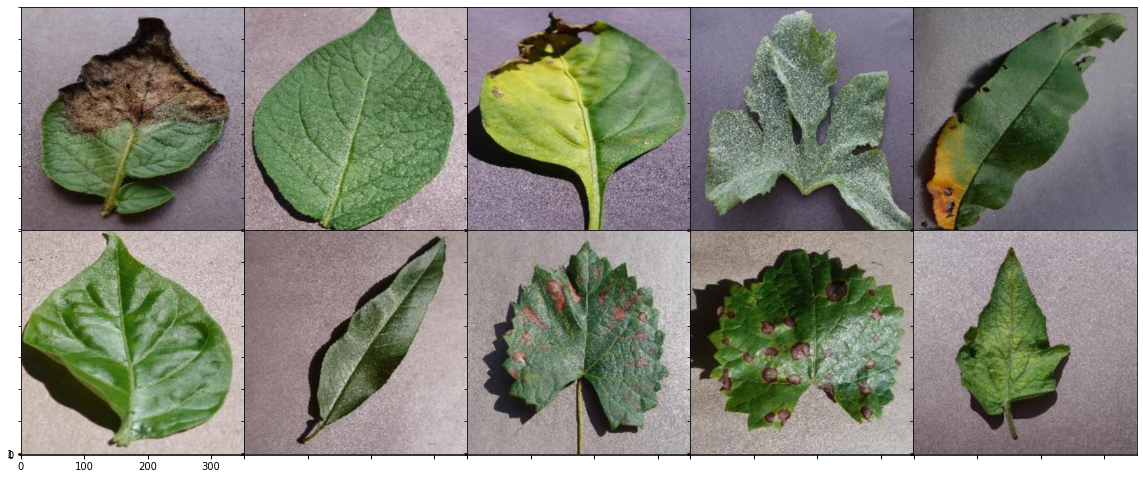

In [ ]:
path = r"data/train"
random_filenames = []
for tag in os.listdir(path):
    random_filenames.append(path+"/"+tag+"/"+random.choice([
        x for x in os.listdir(os.path.join(path,tag))
        if os.path.isfile(os.path.join(path,tag, x))
    ]))

grid = AxesGrid(plt.figure(1, (20,20)), 111, nrows_ncols=(4, 5), axes_pad=0, label_mode="1")

i = 0
for img_name in random_filenames[0:10]:
    
    # Download image
    image = cv2.imread(img_name)
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show image in grid
    grid[i].imshow(image)
    i = i+1

In [ ]:
# init_weights=True

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracy_stats = {'train': [], "val": []}
    loss_stats = {'train': [], "val": []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print("Reached first for loop:",phase)
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            print("phase:", phase, "runningLoss:", running_loss, "datasetSize", dataset_sizes[phase])
            print("preds:", preds, "\n")
            print("labels:", labels, "\n")
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            loss_stats[phase].append(epoch_loss)
#             loss_stats['val'].append(val_epoch_loss/len(val_loader))
            accuracy_stats[phase].append(np.float(epoch_acc))
#             accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
            
#             results = {
#                 "loss": epoch_loss,
#                 "precision": precision_score(labels.data.to('cpu'), preds.data.to('cpu'), average="weighted"),
#                 "recall": recall_score(labels.data.to('cpu'), preds.data.to('cpu'), average="weighted"),
#                 "f1": f1_score(labels.data.to('cpu'), preds.data.to('cpu'), average="weighted")
#             }
            
#             print(results)
            
            print("Loss = {}\n".format(np.float(epoch_loss)))
            print("Acc = {}\n".format(np.float(epoch_acc)))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

#         print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, accuracy_stats, loss_stats


In [ ]:
# data_path = os.path.join(args.data_folder,'simpsonslego-v2')
# data_path = args.data_folder
data_path = r"data"

### Prepare the dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = models.mobilenet_v2(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, accuracy_stats, loss_stats = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)

# Save the model
torch.save(model_ft, '/content/model.pth')

# Save the labels
with open('/content/labels.txt', 'w') as f:
    f.writelines(["%s\n" % item  for item in class_names])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Epoch 0/3
----------
Reached first for loop: train
phase: train runningLoss: 5151.9575716725085 datasetSize 14145
preds: tensor([6], device='cuda:0') 

labels: tensor([4], device='cuda:0') 

Loss = 0.3642246427481448

Acc = 0.8856132909155179

Reached first for loop: val
phase: val runningLoss: 354.06362818348316 datasetSize 3534
preds: tensor([11, 12], device='cuda:0') 

labels: tensor([11, 12], device='cuda:0') 

Loss = 0.10018778386629405

Acc = 0.9668930390492361

Epoch 1/3
----------
Reached first for loop: train
phase: train runningLoss: 2098.5448931075516 datasetSize 14145
preds: tensor([3], device='cuda:0') 

labels: tensor([13], device='cuda:0') 

Loss = 0.1483594834293073

Acc = 0.9535524920466596

Reached first for loop: val
phase: val runningLoss: 262.3687669946098 datasetSize 3534
preds: tensor([1, 0], device='cuda:0') 

labels: tensor([1, 0], device='cuda:0') 

Loss = 0.07424130362043288

Acc = 0.9742501414827391

Epoch 2/3
----------
Reached first for loop: train
phase:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

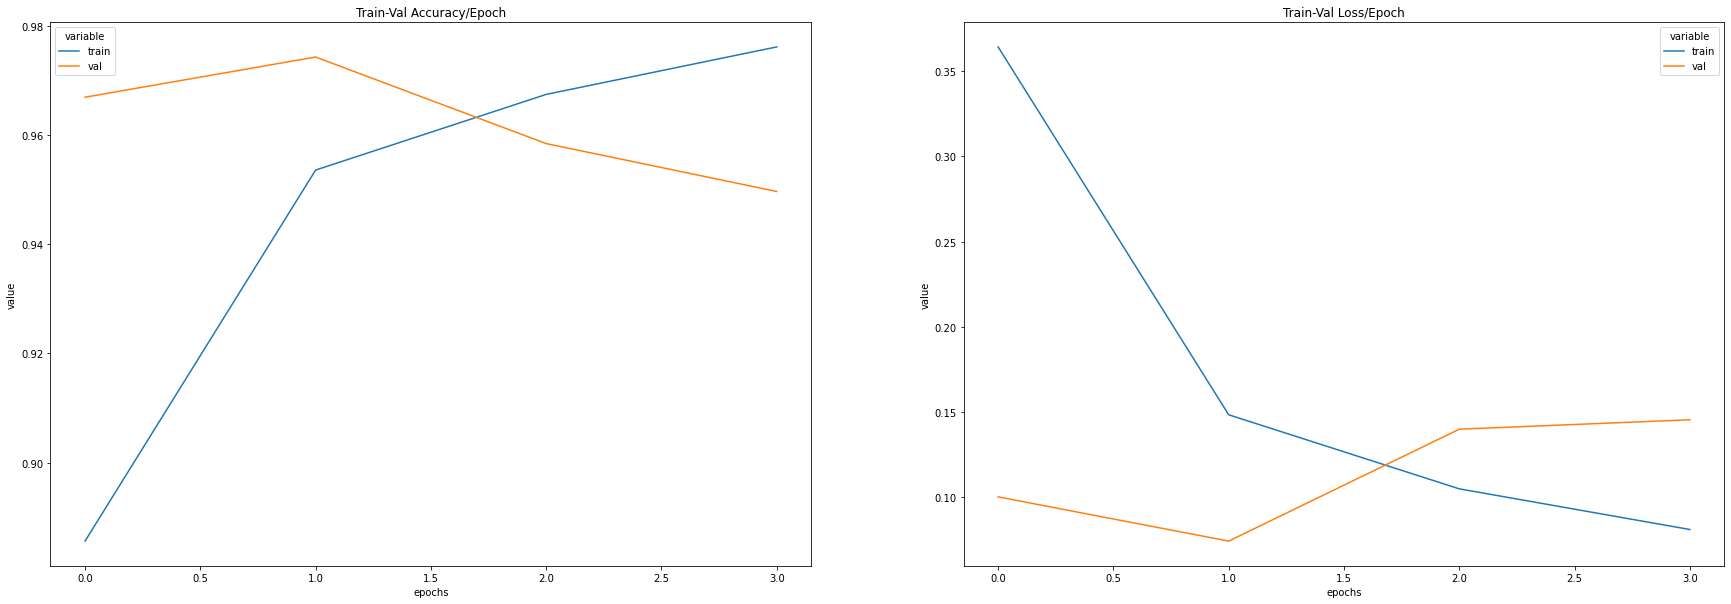

In [ ]:
import pandas as pd
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
y_pred_list = []
y_true_list = []
phase='val'
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # y_test_pred = model_ft(inputs)
        outputs = model_ft(inputs)
        # outputs = torch.log_softmax(outputs, dim=1)
        _, preds = torch.max(outputs, dim=1)
        y_pred_list.append(preds.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

In [ ]:
# y_pred_list


In [ ]:
y_true_list[0]

array([3, 3, 8, 0])

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]


In [ ]:
len(y_true_list)

884

In [ ]:
results = {
    "precision": precision_score(y_true_list, y_pred_list, average="weighted"),
    "recall": recall_score(y_true_list, y_pred_list,  average="weighted"),
    "f1": f1_score(y_true_list, y_pred_list, average="weighted")
}
print(results)

{'precision': 0.9695126227890627, 'recall': 0.9649321266968326, 'f1': 0.9655008552925898}


In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        64
           2       0.90      1.00      0.95        19
           3       0.99      0.97      0.98        95
           4       1.00      1.00      1.00        16
           5       1.00      0.94      0.97        47
           6       0.95      0.96      0.95        76
           7       0.84      1.00      0.91        51
           8       1.00      0.87      0.93        46
           9       0.67      1.00      0.80        10
          10       0.93      1.00      0.96       103
          11       1.00      0.99      1.00       120
          12       0.99      0.94      0.96        97
          13       1.00      0.88      0.94        74

    accuracy                           0.96       884
   macro avg       0.95      0.97      0.95       884
weighted avg       0.97      0.96      0.97       884



In [ ]:
cf=confusion_matrix(y_true_list, y_pred_list)
print(cf)

[[ 66   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  64   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  19   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  92   0   0   0   1   0   0   2   0   0   0]
 [  0   0   0   0  16   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  44   2   1   0   0   0   0   0   0]
 [  0   0   2   0   0   0  73   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0  51   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   5  40   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 103   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0 119   0   0]
 [  0   0   0   0   0   0   0   3   0   0   3   0  91   0]
 [  0   0   0   0   0   0   2   0   0   3   3   0   1  65]]


In [ ]:
from cf_matrix import make_confusion_matrix

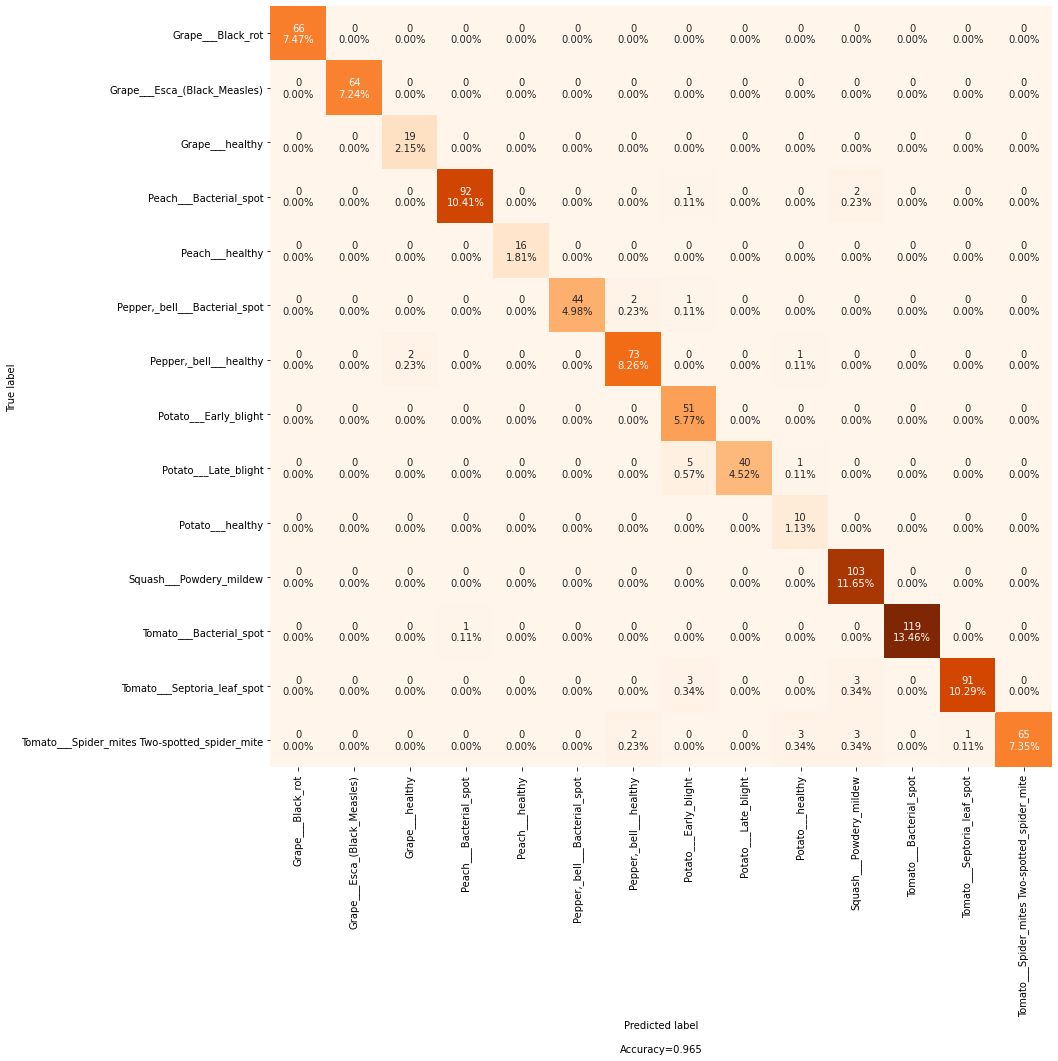

In [ ]:

categories = class_names
# print(class_names)
make_confusion_matrix(cf,
                      categories=categories, 
                      cmap='Oranges',
                      figsize=(14,14),
                      cbar=False,
                      sum_stats=True
                      )

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
import urllib
from PIL import Image
# Load the model
loaded_model = torch.load('model.pth')
loaded_model.eval()

# Load the labels
with open('labels.txt', 'rt') as lf:
    global labels
    labels = [l.strip() for l in lf.readlines()]

    
def scoreImage(image_link):
    # Load the image to predict
    input_image = Image.open(image_link)

    # Pre process
    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Predict the image
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        loaded_model.to('cuda')

    with torch.no_grad():
        output = loaded_model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

    #Return the result
    return {"label": labels[index], "probability": round(probability*100,2)}



path = r"data/test/"
i = 0
grid= AxesGrid(plt.figure(1, (20,20)), 111, nrows_ncols=(50, 50), axes_pad=0, label_mode="1")
for plant in os.listdir(path):
  
  for image in os.listdir(os.path.join(path,plant)):
    # print(os.path.join(path,plant,image))
    result = scoreImage(os.path.join(path,plant,image))
    # Download image
    image = cv2.imread(os.path.join(path,plant,image))
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(image, "{} - {}%".format(result['label'],result['probability']),(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,0,0),2,cv2.LINE_AA)    
    
    grid[i].imshow(image)
    i = i+1

In [ ]:
# !zip -r data_test_val_train.zip /content/data

In [ ]:
# import shutil
# for images in os.listdir('/content/data/train'):
#   # print(len())
#   min_len=20
#   i=0
#   for getimages in os.listdir(os.path.join('/content/data/train',images)):
#     if i<=min_len:
#       print(os.path.join('/content/data/train',images,getimages))
#       test_path='/content/data/test'
#       if not os.path.exists(os.path.join(test_path,images)):
#         os.mkdir(os.path.join(test_path,images))
#       if os.path.exists(os.path.join(test_path,images)):
#         shutil.move(os.path.join('/content/data/train',images,getimages),os.path.join(test_path,images,getimages))
#       i=i+1
